#FaceRecognition using CNN

The State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with convolutional neural networks (CNNs) that use convolution layers to extract features from images and pooling layers to downsize images so features can be detected at various resolutions. Let's use Keras to build a CNN and train it with the Labeled Faces in the Wild dataset to determine how well a CNN can be trained to perform facial recognition.

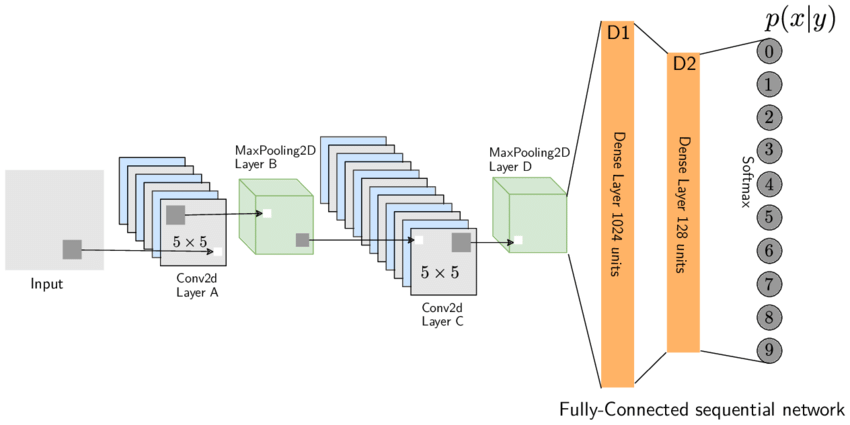

##Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

Unlike in previous examples in which we loaded 47x62 grayscale images from the LFW dataset, this time we will load 128x128 color images. CNNs work better with images that have equal widths and heights, and pretrained CNNs such as ResNet-50 are designed to work with 3-channel color images.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


Use the following code to show the first several images in the dataset and the people to whom the faces belong.

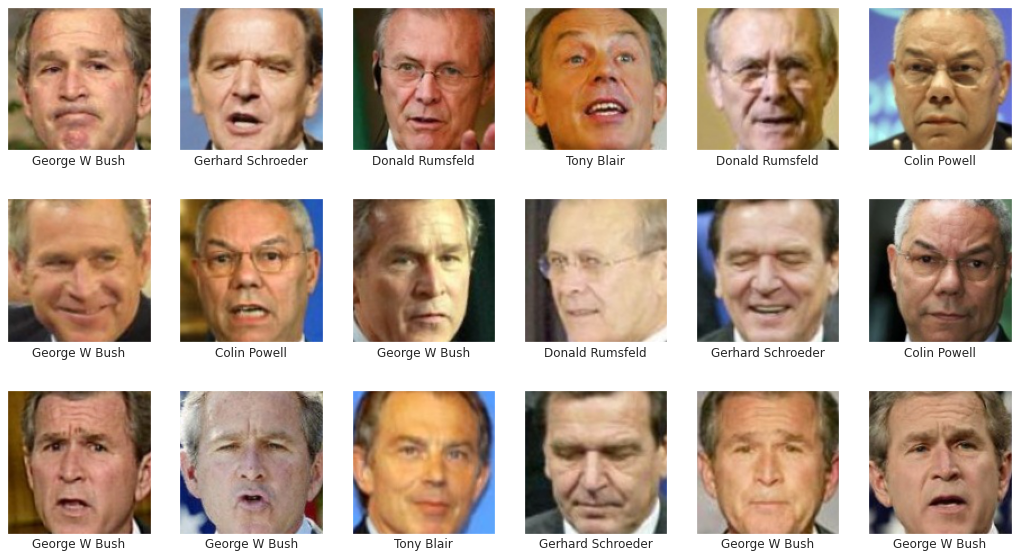

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes, that the CNN will try to predict.



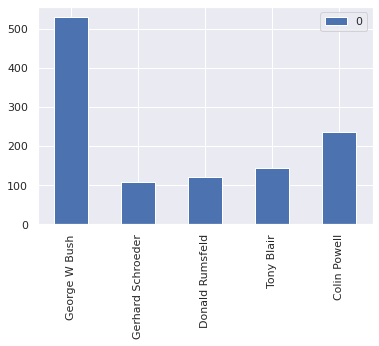

In [3]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

##Classification models are best trained with balanced datasets. The following code is used to build a dataset containing 100 images of each person.

In [4]:
mask = np.zeros(faces.target.shape, dtype=np.bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(500, 128, 128, 3)

###The next step is to normalize pixel values by dividing them by 255 and convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by one-hot-encoding them. Then we'll split the data for training and testing.

In [5]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

face_images = x_faces / 255 # Normalize pixel values
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

##Build and train a convolutional neural network

Now let's build a CNN containing three pairs of convolution and pooling layers followed by a classification layer containing 128 neurons and a softmax layer that outputs probabilities for each class and train it from scratch with LFW images.

In [6]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

***Now call fit to train the model.***

In [7]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=25)

Epoch 1/100
16/16 [==============================] - 21s 1s/step - loss: 1.6721 - accuracy: 0.1750 - val_loss: 1.6062 - val_accuracy: 0.2000
Epoch 2/100
16/16 [==============================] - 11s 666ms/step - loss: 1.5970 - accuracy: 0.2325 - val_loss: 1.5790 - val_accuracy: 0.2200
Epoch 3/100
16/16 [==============================] - 11s 673ms/step - loss: 1.4938 - accuracy: 0.3725 - val_loss: 1.4143 - val_accuracy: 0.3500
Epoch 4/100
16/16 [==============================] - 11s 672ms/step - loss: 1.2411 - accuracy: 0.5425 - val_loss: 1.0741 - val_accuracy: 0.6900
Epoch 5/100
16/16 [==============================] - 11s 669ms/step - loss: 0.7352 - accuracy: 0.7400 - val_loss: 0.7982 - val_accuracy: 0.7200
Epoch 6/100
16/16 [==============================] - 11s 676ms/step - loss: 0.4939 - accuracy: 0.8200 - val_loss: 0.7980 - val_accuracy: 0.7200
Epoch 7/100
16/16 [==============================] - 11s 673ms/step - loss: 0.3658 - accuracy: 0.8800 - val_loss: 0.9527 - val_accuracy: 0.

Plot the training and validation accuracy to see how well the network performed.

[]

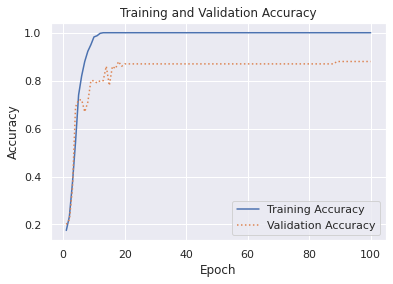

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run some test data through the network and use a confusion matrix to see how it fared.

Text(89.18, 0.5, 'Actual label')

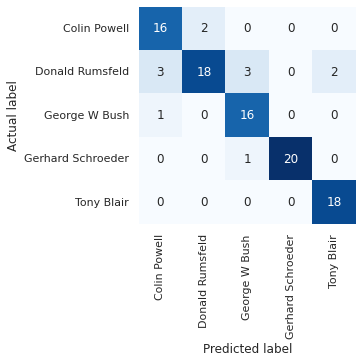

In [9]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

How many times did the network correctly identify George W. Bush? How many times did it fail to identify him?

##Prediction

Load a picture of George W. Bush downloaded from the Internet that has been cropped to 128x128 and use it to make a prediction. The first step is to load the image.

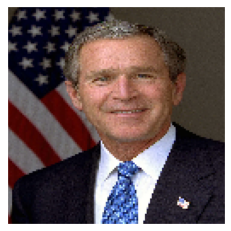

In [10]:
from keras.preprocessing import image

x = image.load_img('George-W-Bush.jpeg', target_size=(face_images.shape[1:]))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Now see if the CNN can identify the person in the picture.

In [11]:
x = image.img_to_array(x) / 255
x = np.expand_dims(x, axis=0)
y = model.predict(x)[0]

for i in range(len(y)):
    print(faces.target_names[i] + ': ' + str(y[i]))


Colin Powell: 0.99999785
Donald Rumsfeld: 1.363242e-15
George W Bush: 2.1465733e-06
Gerhard Schroeder: 1.9838137e-17
Tony Blair: 3.3514614e-18


Load a picture of tony_blair downloaded from the Internet .

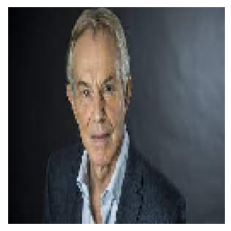

In [12]:
from keras.preprocessing import image

s = image.load_img('tony_blair.jpg', target_size=(face_images.shape[1:]))
plt.xticks([])
plt.yticks([])
plt.imshow(s)

In [13]:
s = image.img_to_array(s) / 255
s = np.expand_dims(s, axis=0)
k = model.predict(s)[0]

for i in range(len(k)):
    print(faces.target_names[i] + ': ' + str(k[i]))


Colin Powell: 4.20687e-09
Donald Rumsfeld: 5.8471507e-08
George W Bush: 0.002761987
Gerhard Schroeder: 0.9972379
Tony Blair: 4.069717e-08


Load a picture of Donald Rumsfeld downloaded from the Internet.

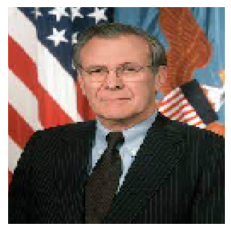

In [14]:
from keras.preprocessing import image

d = image.load_img('Donald Rumsfeld.jpg', target_size=(face_images.shape[1:]))
plt.xticks([])
plt.yticks([])
plt.imshow(d)

In [15]:
d = image.img_to_array(d) / 255
d = np.expand_dims(d, axis=0)
r = model.predict(d)[0]

for i in range(len(r)):
    print(faces.target_names[i] + ': ' + str(r[i]))


Colin Powell: 0.9999982
Donald Rumsfeld: 1.4333318e-17
George W Bush: 1.8330387e-06
Gerhard Schroeder: 9.346701e-19
Tony Blair: 3.8605246e-27
